In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchvision import transforms
from avalanche.benchmarks.datasets import MNIST
from avalanche.benchmarks.datasets.dataset_utils import default_dataset_location
from avalanche.benchmarks.utils import as_classification_dataset, AvalancheDataset


from avalanche.benchmarks.classic import SplitMNIST
from avalanche.benchmarks.generators import nc_benchmark
from avalanche.models import SimpleMLP
from avalanche.training import Naive, Cumulative, ICaRL, EWC, Replay
from avalanche.training.plugins import (
    ReplayPlugin,
    EWCPlugin,
    AGEMPlugin,
    EvaluationPlugin,
    LwFPlugin,
)
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
    timing_metrics,
    cpu_usage_metrics,
    confusion_matrix_metrics,
    disk_usage_metrics,
)
from avalanche.logging import InteractiveLogger

from pytorch_ood.detector import OpenMax, EnergyBased, Entropy
from pytorch_ood.utils import OODMetrics

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy

from utils.fm import init_logger, set_all_seed
from utils.viz import show_batch
from utils.data import (
    count_sample_in_experience,
    count_sample_in_dataset,
    count_sample_in_stream,
    get_full_dataset_experience,
)

from avalanche_ood_plugins.detectors import OODDetectorPlugin

/Users/marcocosseddu/opt/miniconda3/envs/tesi_env1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_data(batch_size=64, seed=0):
    # Location to save/load the MNIST dataset
    datadir = default_dataset_location("mnist")

    # Load the non-corrupted MNIST dataset
    train_MNIST = MNIST(datadir, train=True, download=True)
    test_MNIST = MNIST(datadir, train=False, download=True)

    # Extract train and test data/labels
    train_data = train_MNIST.data.float() / 255  # Normalize data to [0, 1]
    train_labels = train_MNIST.targets
    test_data = test_MNIST.data.float() / 255  # Normalize data to [0, 1]
    test_labels = test_MNIST.targets

    # Load corrupted data and labels
    c_test_images = (
        np.load("./datasets/brightness02/test/test_images.npy").astype(np.float32) / 255
    )  # Normalize
    c_test_labels = np.load("./datasets/brightness02/test/test_labels.npy")
    # c_train_images = (
    #     np.load("./brightness/train/train_images.npy").astype(np.float32) / 255
    # )  # Normalize
    # c_train_labels = np.load("./brightness/train/train_labels.npy")

    # Convert NumPy arrays to tensors and remove channel dimension for images
    c_test_images_tensor = remove_channel_dimension(torch.tensor(c_test_images))
    # c_train_images_tensor = remove_channel_dimension(torch.tensor(c_train_images))

    # Apply the specified mapping to the corrupted labels
    def map_labels(labels):
        return torch.tensor([10 if label == 0 else label + 10 for label in labels])

    c_test_labels_tensor = map_labels(c_test_labels)
    # c_train_labels_tensor = map_labels(c_train_labels)

    # Combine non-corrupted and corrupted data
    combined_test_data = torch.cat(
        [test_data, c_test_images_tensor], dim=0
    )  # Add channel dimension
    combined_test_labels = torch.cat([test_labels, c_test_labels_tensor], dim=0)

    # combined_train_data = torch.cat(
    #     [train_data, c_train_images_tensor], dim=0
    # )  # Add channel dimension
    # combined_train_labels = torch.cat([train_labels, c_train_labels_tensor], dim=0)

    # Create TensorDataset objects
    # train_dataset = TensorDataset(combined_train_data, combined_train_labels)

    combined_test_dataset = TensorDataset(combined_test_data, combined_test_labels)

    # Create a train Dataset
    train_dataset = TensorDataset(train_data, train_labels)
    # Create DataLoader objects
    train_dataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataLoader = DataLoader(
        combined_test_dataset, batch_size=batch_size, shuffle=False
    )

    # Set the desired order of the classes
    desired_order = [
        0,
        10,
        1,
        11,
        2,
        12,
        3,
        13,
        4,
        14,
        5,
        15,
        6,
        16,
        7,
        17,
        8,
        18,
        9,
        19,
    ]

    # Create the CL scenario
    scenario = nc_benchmark(
        combined_test_dataset,
        combined_test_dataset,
        n_experiences=10,
        shuffle=False,
        seed=seed,
        fixed_class_order=desired_order,
        task_labels=True,
    )

    return train_dataLoader, test_dataLoader, scenario


def map_mixed_test(labels):
    return torch.tensor([-1 if label > 9 else label for label in labels])


def map_normal_test(labels, i, j):
    return torch.tensor([-1 if j > i else label for label in labels])


def train_and_eval(
    train_stream,
    normal_test_stream,
    mixed_test_stream,
    cl_strategy,
    seed=0,
    device="cpu",
):
    N_EXPERIENCES = len(train_stream)

    set_all_seed(seed)
    acc_k_matrix = np.zeros(shape=(N_EXPERIENCES, 1))  # Accuracy K Matrix
    forgetting_k_matrix = np.zeros(shape=(N_EXPERIENCES, 1))  # Forgetting K Matrix
    acc_ij_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # Accuracy I,J Matrix
    forgetting_ij_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # Forgetting I,J Matrix
    ood_matrix = np.zeros(shape=(N_EXPERIENCES, N_EXPERIENCES))  # OOD Matrix

    OOD_AUROC_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # OOD AUROC Matrix
    OOD_AUPR_OUT_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # OOD AUPR-OUT Matrix
    OOD_FPR95TPR_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # OOD FPR95TPR Matrix
    OOD_AUPR_IN_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # OOD AUPR-IN Matrix
    IID_AUPR_OUT_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # IID AUPR-OUT Matrix
    IID_FPR95TPR_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # IID FPR95TPR Matrix
    IID_AUPR_IN_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # IID AUPR-IN Matrix
    IID_AUROC_matrix = np.zeros(
        shape=(N_EXPERIENCES, N_EXPERIENCES)
    )  # IID AUROC Matrix

    OOD_metrics_large = OODMetrics()
    IID_metrics_large = OODMetrics()

    for i, train_exp in enumerate(train_stream):
        set_all_seed(seed)
        cl_strategy.train(train_exp)
        results = cl_strategy.eval(normal_test_stream)
        acc_k_matrix[i, 0] = results[
            f"Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000"
        ]
        forgetting_k_matrix[i, 0] = results[f"StreamForgetting/eval_phase/test_stream"]
        print(results)

        # Evaluation and OOD Scores on IID Data
        IID_metrics_narrow = OODMetrics()
        for j, test_exp in enumerate(normal_test_stream):
            acc_ij_matrix[i, j] = results[
                f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{str(j).zfill(3)}"
            ]
            if j < i:
                forgetting_ij_matrix[i, j] = results[
                    f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{str(j).zfill(3)}"
                ]

            # OOD Detection
            set_all_seed(seed)
            test_loader = DataLoader(test_exp.dataset, batch_size=32, shuffle=True)
            ood_scores = torch.tensor([]).to(device)
            # OOD Scores computing
            for batch in test_loader:
                if len(batch) == 2:
                    x, y = batch
                else:
                    x, y, *_ = batch

                for plugin in cl_strategy.plugins:
                    if isinstance(plugin, OODDetectorPlugin):
                        detector = plugin.detector
                    y = map_normal_test(y, i, j)
                    ood_score_k = detector.predict(x)
                    ood_scores = torch.cat((ood_scores, ood_score_k))
                    IID_metrics_narrow.update(detector(x), y)
                    IID_metrics_large.update(detector(x), y)

            ood_matrix[i, j] = ood_scores.mean()
            if j > i:
                dict_IID_M_narrow = IID_metrics_narrow.compute()
                IID_AUROC_matrix[i, j] = dict_IID_M_narrow["AUROC"]
                IID_AUPR_IN_matrix[i, j] = dict_IID_M_narrow["AUPR-IN"]
                IID_AUPR_OUT_matrix[i, j] = dict_IID_M_narrow["AUPR-OUT"]
                IID_FPR95TPR_matrix[i, j] = dict_IID_M_narrow["FPR95TPR"]

        for z, c_test_exp in enumerate(mixed_test_stream):
            set_all_seed(seed)
            test_loader = DataLoader(c_test_exp.dataset, batch_size=32, shuffle=True)
            OOD_metrics_narrow = OODMetrics()

            for batch in test_loader:
                if len(batch) == 2:
                    x, y = batch
                else:
                    x, y, *_ = batch

                for plugin in cl_strategy.plugins:
                    if isinstance(plugin, OODDetectorPlugin):
                        detector = plugin.detector
                    y = map_mixed_test(y)
                    OOD_metrics_narrow.update(detector(x), y)
                    OOD_metrics_large.update(detector(x), y)
            dict_OOD_M_narrow = OOD_metrics_narrow.compute()
            OOD_AUROC_matrix[i, z] = dict_OOD_M_narrow["AUROC"]
            OOD_AUPR_IN_matrix[i, z] = dict_OOD_M_narrow["AUPR-IN"]
            OOD_AUPR_OUT_matrix[i, z] = dict_OOD_M_narrow["AUPR-OUT"]
            OOD_FPR95TPR_matrix[i, z] = dict_OOD_M_narrow["FPR95TPR"]

    print("Future IID OOD metrics ", IID_metrics_large.compute())
    print("Corrupted images OOD metrics ", OOD_metrics_large.compute())
    IID_AUROC_matrix = np.round(IID_AUROC_matrix, decimals=4)
    OOD_AUROC_matrix = np.round(OOD_AUROC_matrix, decimals=4)
    acc_ij_matrix = np.round(acc_ij_matrix, decimals=4)
    ood_matrix = np.round(ood_matrix, decimals=4)
    acc_k_matrix = np.round(acc_k_matrix, decimals=4)
    forgetting_k_matrix = np.round(forgetting_k_matrix, decimals=4)
    forgetting_ij_matrix = np.round(forgetting_ij_matrix, decimals=4)

    return (
        acc_ij_matrix,
        ood_matrix,
        acc_k_matrix,
        forgetting_k_matrix,
        forgetting_ij_matrix,
        OOD_AUROC_matrix,
        OOD_AUPR_IN_matrix,
        OOD_AUPR_OUT_matrix,
        OOD_FPR95TPR_matrix,
        IID_AUROC_matrix,
        IID_AUPR_IN_matrix,
        IID_AUPR_OUT_matrix,
        IID_FPR95TPR_matrix,
    )


def remove_channel_dimension(dataset):
    modified_data = []
    for data in dataset:
        modified_data.append(data.squeeze(-1))  # Remove the last channel dimension
    return torch.stack(modified_data)  # Stack the modified data and return as a tensor    # Load the pre-trained ResNet18 model
    model = models.resnet18(pretrained=True)

    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )

    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Flatten(),  # This flattens the output of the last conv layer
        torch.nn.Linear(
            num_ftrs, num_classes
        ),  # Adjusts to the desired number of classes
    )

    return model

In [8]:
def main_definiton_train():
    
    N_EXPERIENCES = 10
    EPOCHS = 1
    SEED = 0

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    set_all_seed(SEED)

    benchmark = SplitMNIST(
        n_experiences=N_EXPERIENCES, shuffle=False, dataset_root="datasets"
    )
    train_stream, test_stream = benchmark.train_stream, benchmark.test_stream
    normal_train_dataLoader, combined_test_dataLoader, combined_scenario = load_data()

    model = SimpleMLP(num_classes=10, hidden_size=50)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = CrossEntropyLoss()

    replay = ReplayPlugin(mem_size=50)
    ewc = EWCPlugin(ewc_lambda=1, mode="separate", keep_importance_data=True)
    lwf = LwFPlugin(alpha=0.01, temperature=0.2)
    detector = OpenMax(model, tailsize=50, alpha=10, euclid_weight=0.5)
    detector_plugin = OODDetectorPlugin(detector)

    eval_plugin = EvaluationPlugin(
        accuracy_metrics(experience=True, stream=True, trained_experience=True),
        forgetting_metrics(experience=True, stream=True),
        loggers=[InteractiveLogger()],
    )

    cl_strategy_Naive = Naive(
        model,
        optimizer,
        criterion,
        train_mb_size=32,
        train_epochs=EPOCHS,
        eval_mb_size=32,
        device=DEVICE,
        plugins=[detector_plugin, lwf],
        evaluator=eval_plugin,
    )
    cl_strategy_Cumulative = Cumulative(
        model,
        optimizer,
        criterion,
        train_mb_size=32,
        train_epochs=EPOCHS,
        eval_mb_size=32,
        device=DEVICE,
        plugins=[detector_plugin],
        evaluator=eval_plugin,
    )

    matrices = train_and_eval(
        train_stream,
        test_stream,
        combined_scenario.test_stream,
        cl_strategy_Naive,
        SEED,
        DEVICE,
    )
    titles = [
        "Experience Accuracy",
        "OOD score",
        "Experience Forgetting",
        "Stream Accuracy",
        "Stream Forgetting",
    ]
    titles_ood = ["OOD AUROC Matrix", "IID AUROC Matrix"]
    
    return matrices,titles,titles_ood,N_EXPERIENCES
matrices, titles, titles_ood, N_EXPERIENCES = main_definiton_train()


-- >> Start of training phase << --
100%|██████████| 186/186 [00:00<00:00, 217.24it/s]
Epoch 0 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 31/31 [00:00<00:00, 253.38it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 36/36 [00:00<00:00, 261.08it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 33/33 [00:00<00:00, 256.28it/s]
> Eval on experience 2 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002 = 0.0000
-- Starting eval on experience 3 (Task 0) from test stream --
100%|██████████| 32/32 [00:00<00:00, 253.28it/s]
> Eval on experience 3 (Task 0) from 

/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_4512/284724372.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_4512/284724372.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_ood.show()


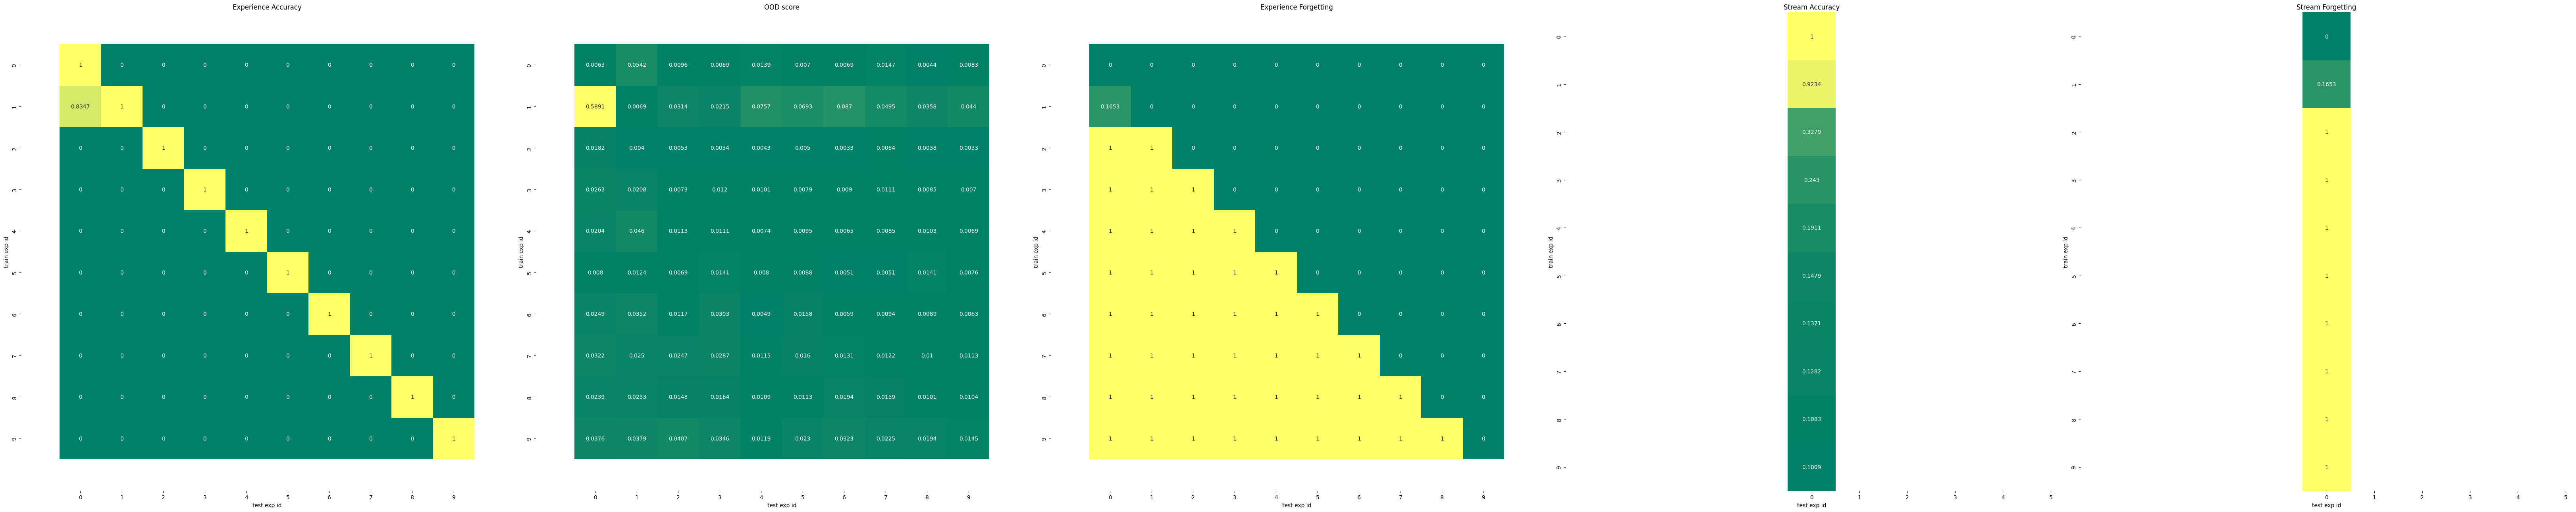

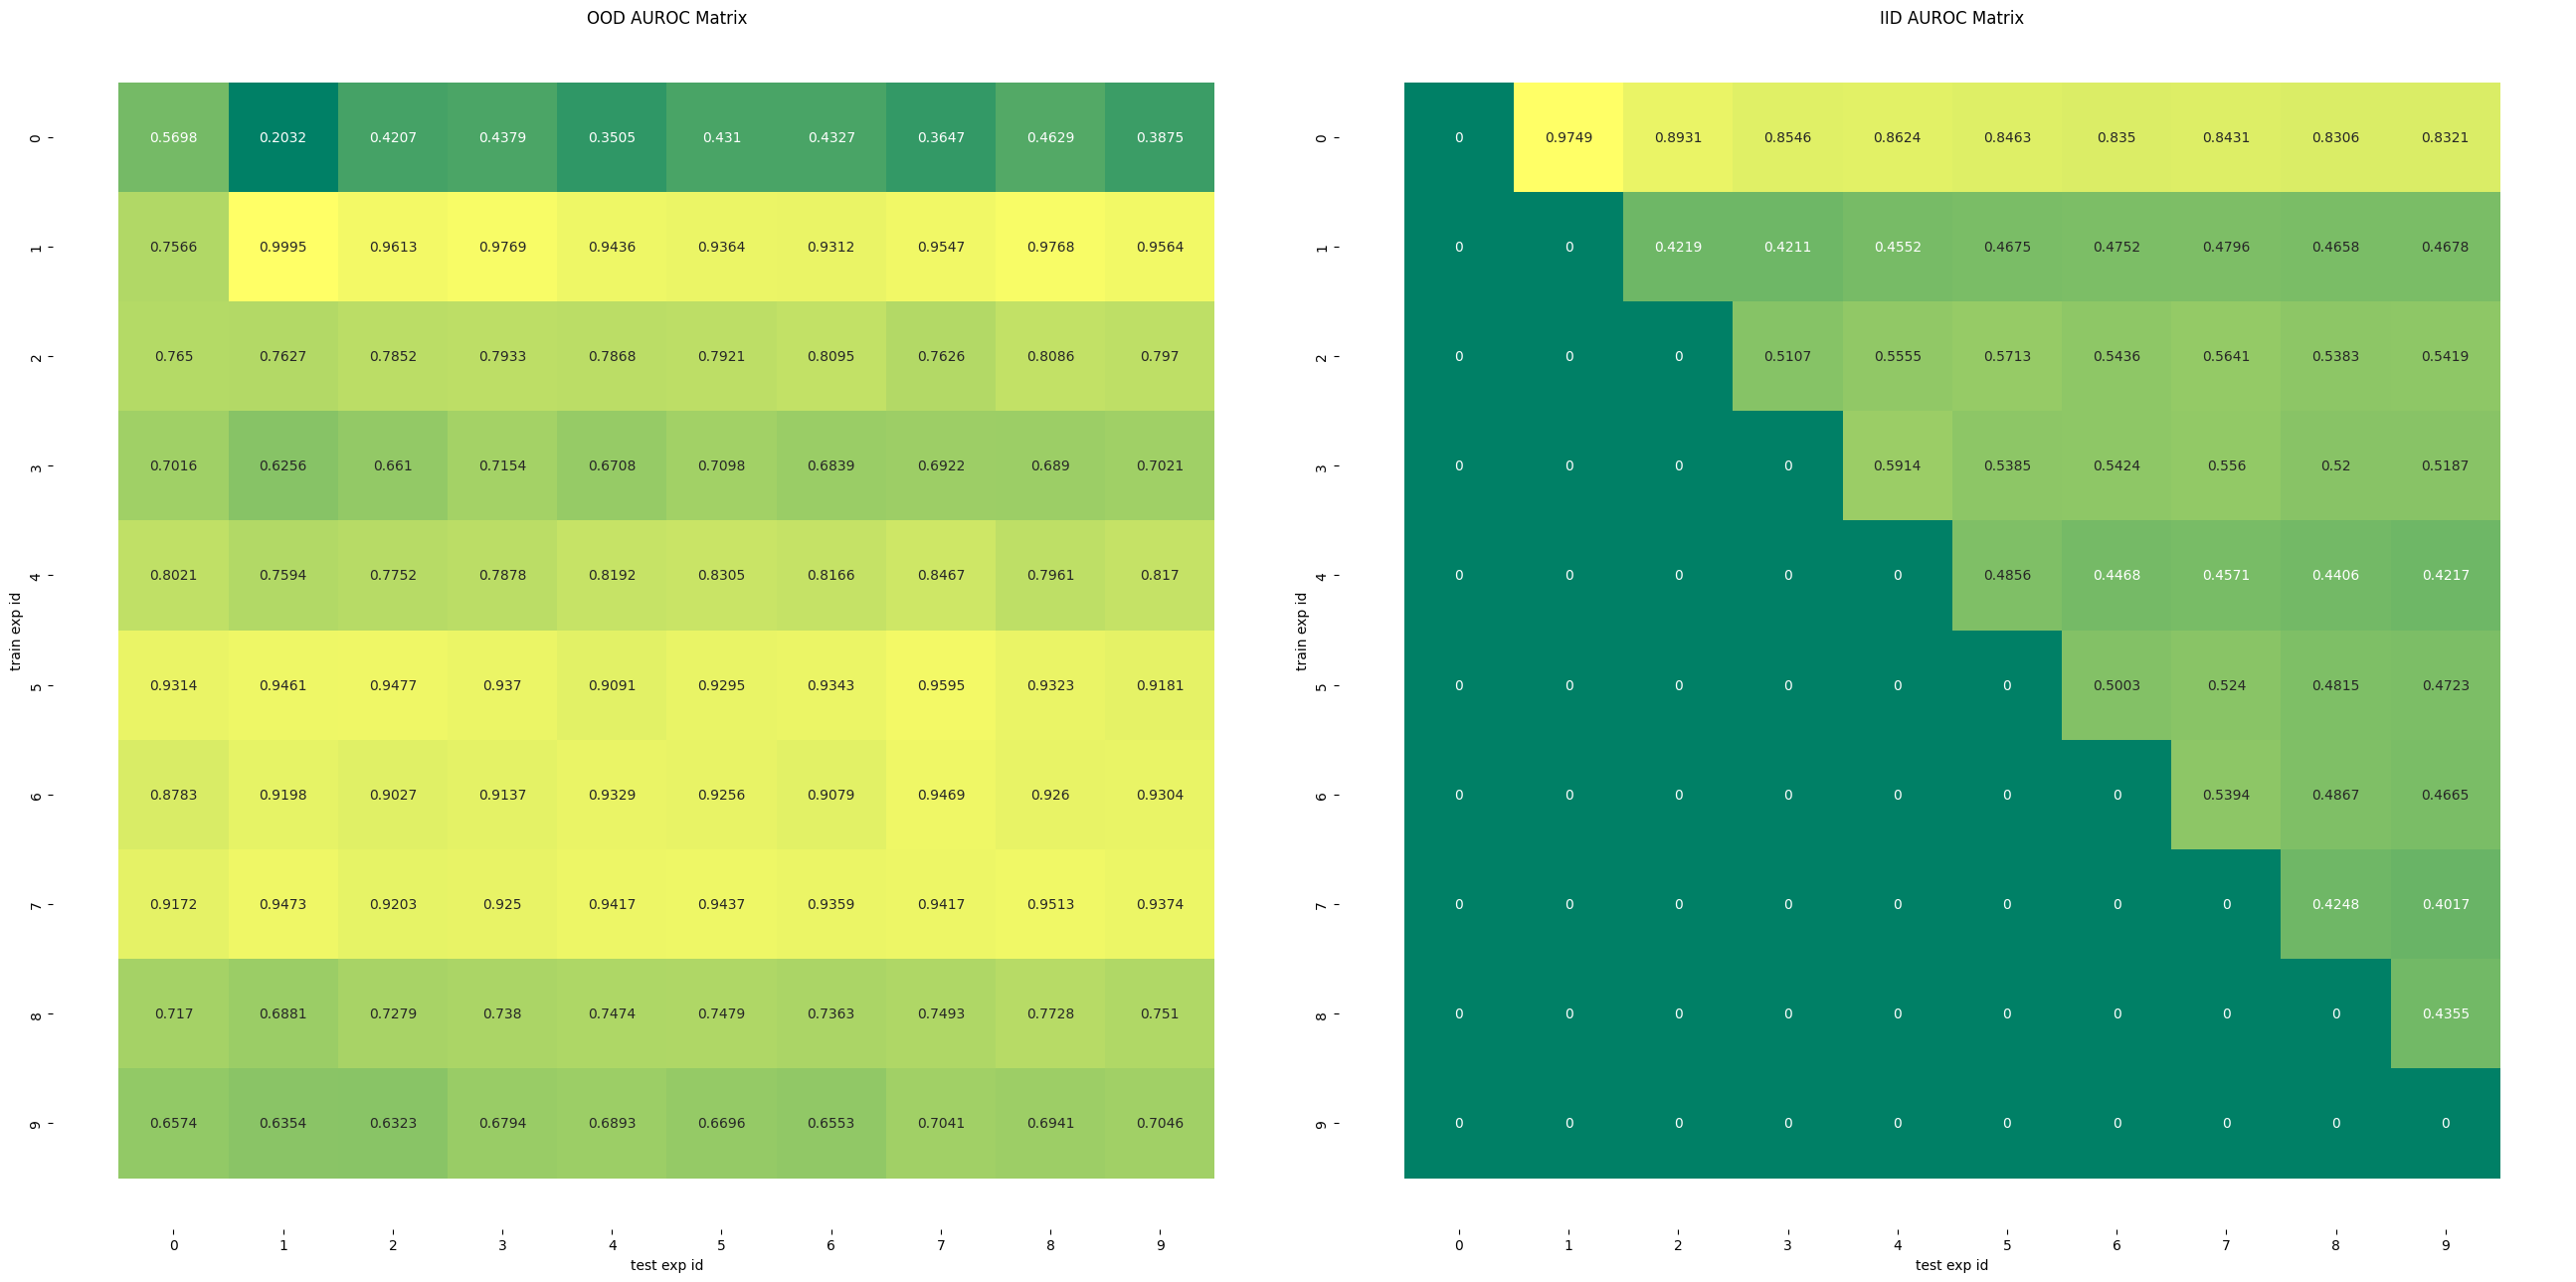

In [11]:
def plot_results(
    acc_ij_matrix,
    ood_matrix,
    acc_k_matrix,
    forgetting_k_matrix,
    forgetting_ij_matrix,
    OOD_AUROC_matrix,
    OOD_AUPR_IN_matrix,
    OOD_AUPR_OUT_matrix,
    OOD_FPR95TPR_matrix,
    IID_AUROC_matrix,
    IID_AUPR_IN_matrix,
    IID_AUPR_OUT_matrix,
    IID_FPR95TPR_matrix,
    titles,
    titles_ood,
    N_EXPERIENCES,
):
    nrows, ncols = 1, 5
    fdim = 13
    fig, axs = plt.subplots(
        nrows, ncols, figsize=(ncols * fdim, nrows * fdim), squeeze=False
    )

    # OOD and IID AUROC Matrices
    fig_ood, axs_ood = plt.subplots(
        nrows, 2, figsize=(2 * fdim, nrows * fdim), squeeze=False
    )

    for i, matrix in enumerate(
        [
            acc_ij_matrix,
            ood_matrix,
            forgetting_ij_matrix,
            acc_k_matrix,
            forgetting_k_matrix,
        ]
    ):
        sns.heatmap(
            matrix,
            annot=True,
            fmt="g",
            ax=axs[0, i],
            cmap="summer",
            cbar=False,
            xticklabels=np.arange(N_EXPERIENCES),
            yticklabels=np.arange(N_EXPERIENCES),
        )
        axs[0, i].set_title(titles[i])
        axs[0, i].axis("equal")
        axs[0, i].set_xlabel("test exp id")
        axs[0, i].set_ylabel("train exp id")

    for j, matrix in enumerate([OOD_AUROC_matrix, IID_AUROC_matrix]):
        sns.heatmap(
            matrix,
            annot=True,
            fmt="g",
            ax=axs_ood[0, j],
            cmap="summer",
            cbar=False,
            xticklabels=np.arange(N_EXPERIENCES),
        )
        axs_ood[0, j].set_title(titles_ood[j])
        axs_ood[0, j].axis("equal")
        axs_ood[0, j].set_xlabel("test exp id")
        axs_ood[0, j].set_ylabel("train exp id")

    fig.tight_layout()
    fig.show()
    os.makedirs("experiments", exist_ok=True)
    fig.savefig("experiments/results.pdf")

    fig_ood.tight_layout()
    fig_ood.show()
    fig_ood.savefig("experiments/OOD_metrics.pdf")

plot_results(
        acc_ij_matrix=matrices[0],
        ood_matrix=matrices[1],
        acc_k_matrix=matrices[2],
        forgetting_k_matrix=matrices[3],
        forgetting_ij_matrix=matrices[4],
        OOD_AUROC_matrix=matrices[5],
        OOD_AUPR_IN_matrix=matrices[6],
        OOD_AUPR_OUT_matrix=matrices[7],
        OOD_FPR95TPR_matrix=matrices[8],
        IID_AUROC_matrix=matrices[9],
        IID_AUPR_IN_matrix=matrices[10],
        IID_AUPR_OUT_matrix=matrices[11],
        IID_FPR95TPR_matrix=matrices[12],
        titles=titles,
        titles_ood=titles_ood,
        N_EXPERIENCES=N_EXPERIENCES,
)